<a href="https://colab.research.google.com/github/youngyoung0511/Sound-AI/blob/Data-processing/1124_onset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# setting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%capture
!pip install PyWavelets librosa matplotlib numpy
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pywt


In [ ]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.signal import find_peaks



'/content/drive/My Drive/soundAI/BoysLikeGirls.mp3'

MagicCarpetRide_drum.mp3

Every Day.mp3

music.mp3 //꿈나라별나라


# onset

In [ ]:
audio_path = '/content/drive/My Drive/soundAI/music.mp3'  # 여기에 mp3 파일 경로를 입력하세요
y, sr = librosa.load(audio_path, sr=None)


In [ ]:
y, sr = librosa.load(audio_path, sr=None)
print(f"Sampling Rate: {sr}")


Sampling Rate: 48000


In [ ]:
def erb_filterbank(y, sr, num_bands=40):
    """
    ERB 필터뱅크를 Mel 필터뱅크로 시뮬레이션하여 주파수 대역 분해.
    """
    # Mel 필터뱅크 생성
    mel_bands = librosa.filters.mel(sr=sr, n_fft=2048, n_mels=num_bands, fmax=sr/2)
    # STFT 계산
    stft = np.abs(librosa.stft(y, n_fft=2048))
    # Mel 대역별로 신호를 분해
    erb_bands = np.dot(mel_bands, stft)
    return erb_bands



In [ ]:
# 3. Correntropy 기반 탐지 함수 생성
def correntropy_detection(erb_bands):
    """
    Correntropy를 기반으로 탐지 함수 계산
    """
    detection_function = np.mean(erb_bands, axis=0)  # 대략적인 평균
    return detection_function

In [ ]:
# 4. 피크 탐지 (온셋 및 오프셋)
def detect_onset_offset(detection_function, sr, threshold=0.1, min_distance=50):
    """
    탐지 함수에서 피크를 찾아 온셋과 오프셋 계산
    """
    peaks, _ = find_peaks(detection_function, height=threshold, distance=min_distance)
    return peaks

In [ ]:
# 5. 결과 시각화
def plot_results(y, sr, detection_function, onsets):
    time = np.arange(len(y)) / sr
    plt.figure(figsize=(15, 6))

    # 원래 신호
    plt.subplot(2, 1, 1)
    plt.plot(time, y, label='Original Signal')
    plt.scatter(onsets / sr, [0]*len(onsets), color='r', label='Detected Onsets', zorder=5)
    plt.legend(loc='upper right')
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("Audio Signal with Detected Onsets")

    # 탐지 함수
    plt.subplot(2, 1, 2)
    time_d = np.linspace(0, len(y)/sr, len(detection_function))
    plt.plot(time_d, detection_function, label='Detection Function', color='g')
    plt.scatter(onsets / sr, detection_function[onsets], color='r', label='Peaks (Onsets)', zorder=5)
    plt.legend(loc='upper right')
    plt.xlabel("Time (s)")
    plt.ylabel("Detection Function Value")
    plt.title("Detection Function with Peaks")
    plt.tight_layout()
    plt.show()

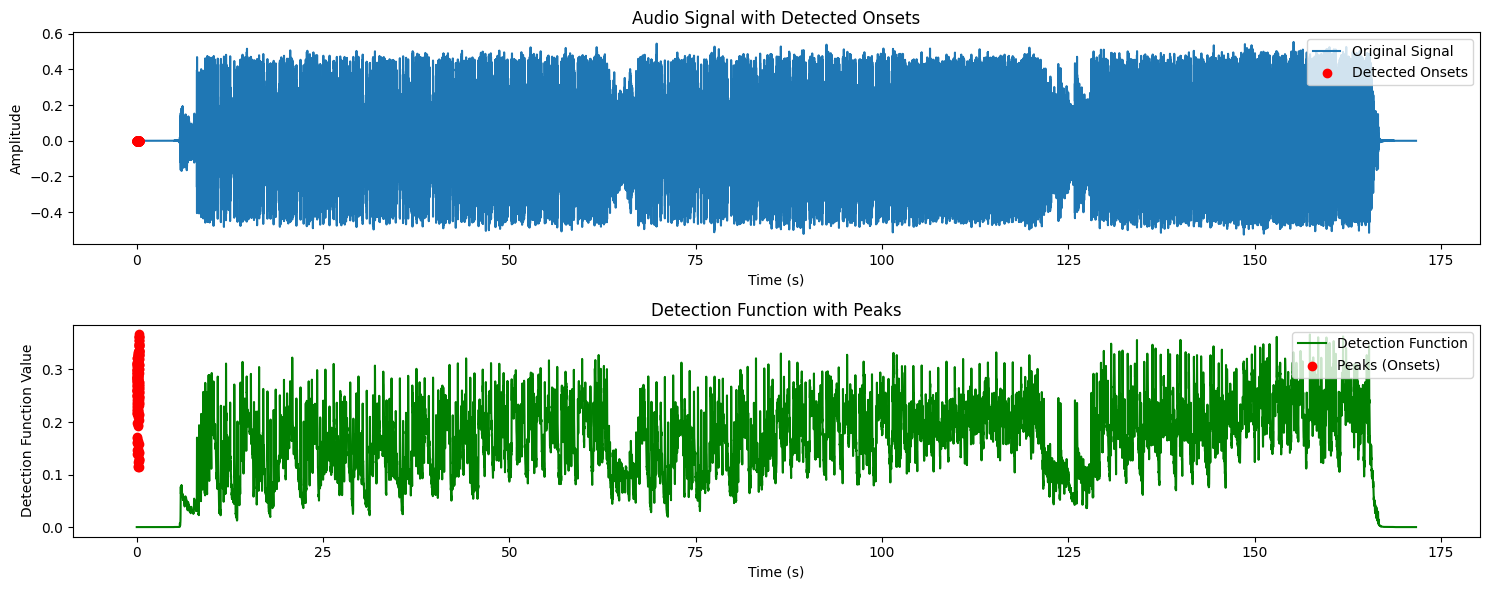

In [ ]:
# ERB 필터뱅크 적용
erb_bands = erb_filterbank(y, sr)

# 탐지 함수 계산
detection_function = correntropy_detection(erb_bands)

# 온셋 및 오프셋 탐지
onsets = detect_onset_offset(detection_function, sr)

# 결과 시각화
plot_results(y, sr, detection_function, onsets)

In [ ]:
def rms_energy_detection(y, frame_length=2048, hop_length=512):
    """
    RMS 에너지 기반 탐지 함수 생성
    """
    rms_energy = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
    return rms_energy


In [ ]:
def detect_onset_offset(detection_function, sr, threshold=None, min_distance=50):
    """
    탐지 함수에서 피크를 찾아 온셋과 오프셋 계산
    """
    if threshold is None:
        threshold = 0.8 * np.max(detection_function)  # 기본 임계값 설정

    peaks, _ = find_peaks(detection_function, height=threshold, distance=min_distance)
    return peaks


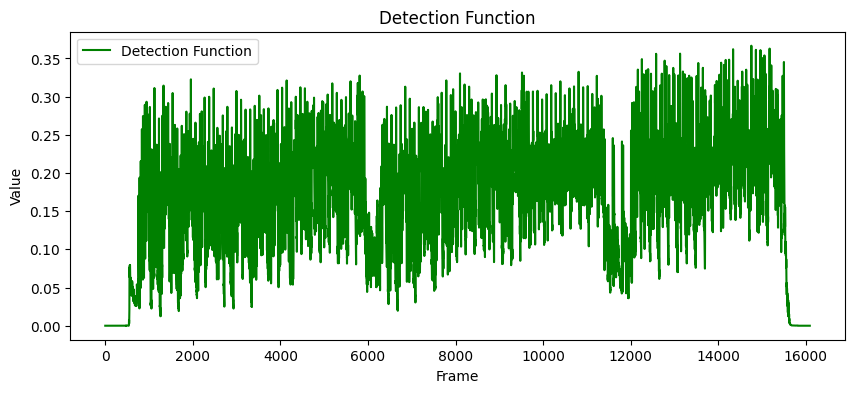

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(detection_function, label="Detection Function", color='green')
plt.title("Detection Function")
plt.xlabel("Frame")
plt.ylabel("Value")
plt.legend()
plt.show()


In [ ]:
# 탐지 함수 정규화
detection_function = (detection_function - np.min(detection_function)) / (np.max(detection_function) - np.min(detection_function))


잡음 제거

In [ ]:
from scipy.ndimage import gaussian_filter1d

# 탐지 함수 평활화
detection_function_smoothed = gaussian_filter1d(detection_function, sigma=5)


In [ ]:
# 피크 탐지 조건 조정
peaks, _ = find_peaks(detection_function_smoothed, height=0.3, distance=200)


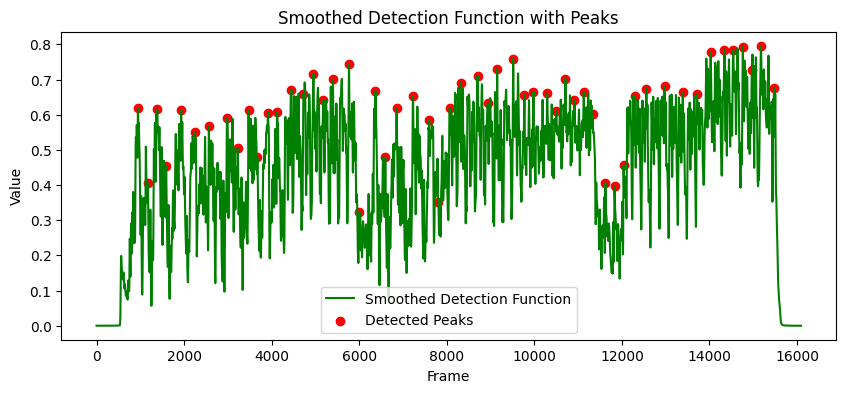

In [ ]:
# 탐지 함수 시각화
plt.figure(figsize=(10, 4))
plt.plot(detection_function_smoothed, label="Smoothed Detection Function", color='green')
plt.scatter(peaks, detection_function_smoothed[peaks], color='red', label='Detected Peaks')
plt.title("Smoothed Detection Function with Peaks")
plt.xlabel("Frame")
plt.ylabel("Value")
plt.legend()
plt.show()


위는 탐지 함수가 잘 평활화되었고 피크도 잘 일치됨.
이제 온셋과 오프셋 감지해서 음표의 길이 확인

오프셋 탐지


In [ ]:
# 오프셋 탐지 함수
def detect_offsets(detection_function, sr, threshold=None, min_distance=50):
    """
    탐지 함수에서 오프셋 계산
    """
    if threshold is None:
        threshold = 0.8 * np.max(detection_function)  # 기본 임계값 설정

    # 탐지 함수를 반전하여 피크를 탐지
    inverted_function = -detection_function
    offsets, _ = find_peaks(inverted_function, height=-threshold, distance=min_distance)
    return offsets

# 오프셋 탐지
offsets = detect_offsets(detection_function_smoothed, sr)


온셋과 오프셋 매칭

In [ ]:
for onset, offset in zip(onsets, offsets):
    print(f"Note: Start={onset/sr:.2f}s, End={offset/sr:.2f}s")


Note: Start=0.02s, End=0.01s
Note: Start=0.02s, End=0.01s
Note: Start=0.02s, End=0.01s
Note: Start=0.02s, End=0.02s
Note: Start=0.02s, End=0.02s
Note: Start=0.02s, End=0.02s
Note: Start=0.02s, End=0.02s
Note: Start=0.02s, End=0.02s
Note: Start=0.03s, End=0.02s
Note: Start=0.03s, End=0.02s
Note: Start=0.03s, End=0.03s
Note: Start=0.03s, End=0.03s
Note: Start=0.03s, End=0.03s
Note: Start=0.03s, End=0.03s
Note: Start=0.03s, End=0.03s
Note: Start=0.03s, End=0.03s
Note: Start=0.04s, End=0.04s
Note: Start=0.04s, End=0.04s
Note: Start=0.04s, End=0.04s
Note: Start=0.04s, End=0.04s
Note: Start=0.04s, End=0.04s
Note: Start=0.04s, End=0.05s
Note: Start=0.04s, End=0.05s
Note: Start=0.04s, End=0.05s
Note: Start=0.05s, End=0.05s
Note: Start=0.05s, End=0.05s
Note: Start=0.05s, End=0.05s
Note: Start=0.05s, End=0.05s
Note: Start=0.05s, End=0.05s
Note: Start=0.05s, End=0.06s
Note: Start=0.05s, End=0.06s
Note: Start=0.05s, End=0.06s
Note: Start=0.06s, End=0.06s
Note: Start=0.06s, End=0.06s
Note: Start=0.

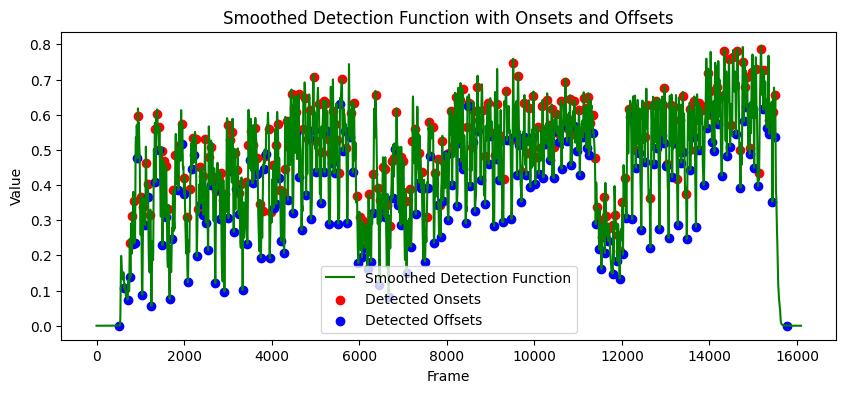

In [ ]:
# 탐지 함수와 온셋/오프셋 시각화
plt.figure(figsize=(10, 4))
plt.plot(detection_function_smoothed, label="Smoothed Detection Function", color='green')
plt.scatter(onsets, detection_function_smoothed[onsets], color='red', label='Detected Onsets')
plt.scatter(offsets, detection_function_smoothed[offsets], color='blue', label='Detected Offsets')
plt.title("Smoothed Detection Function with Onsets and Offsets")
plt.xlabel("Frame")
plt.ylabel("Value")
plt.legend()
plt.show()


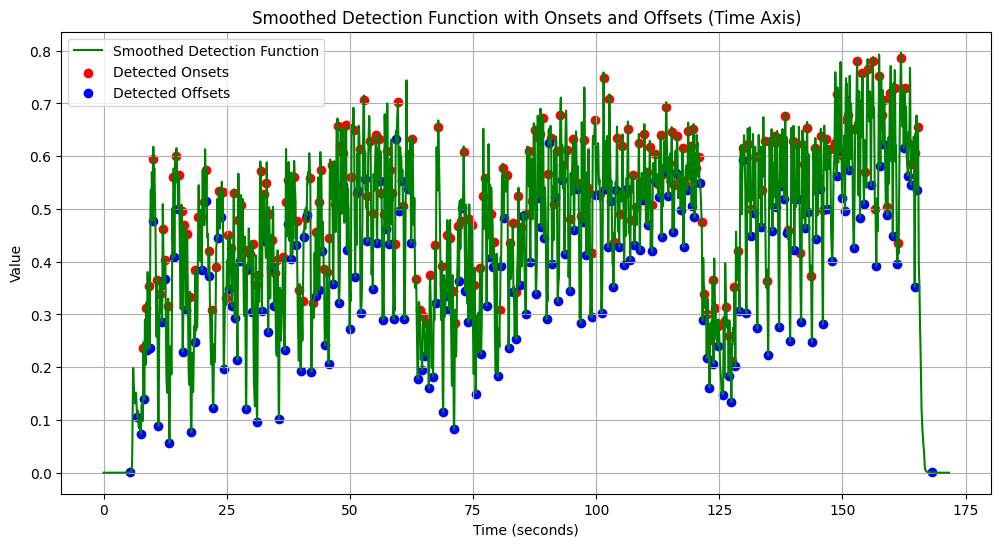

In [ ]:
# STFT의 hop_length (librosa 기본값 사용)
hop_length = 512  # STFT에서 한 프레임의 샘플 간 거리

# 탐지 함수와 온셋/오프셋의 시간 변환
time_axis = np.arange(len(detection_function_smoothed)) * hop_length / sr
onsets_time = [onset * hop_length / sr for onset in onsets]
offsets_time = [offset * hop_length / sr for offset in offsets]

# 시각화: 시간 축 기반 온셋과 오프셋
plt.figure(figsize=(12, 6))
plt.plot(time_axis, detection_function_smoothed, label="Smoothed Detection Function", color='green')

# 온셋과 오프셋 표시
plt.scatter(onsets_time, [detection_function_smoothed[onset] for onset in onsets], color='red', label='Detected Onsets')
plt.scatter(offsets_time, [detection_function_smoothed[offset] for offset in offsets], color='blue', label='Detected Offsets')

# 그래프 설정
plt.title("Smoothed Detection Function with Onsets and Offsets (Time Axis)")
plt.xlabel("Time (seconds)")
plt.ylabel("Value")
plt.legend()
plt.grid(True)

# 결과 출력
plt.show()


이 뽑힌 온셋 데이터를 모델 입력용으로 가공하기


In [ ]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt


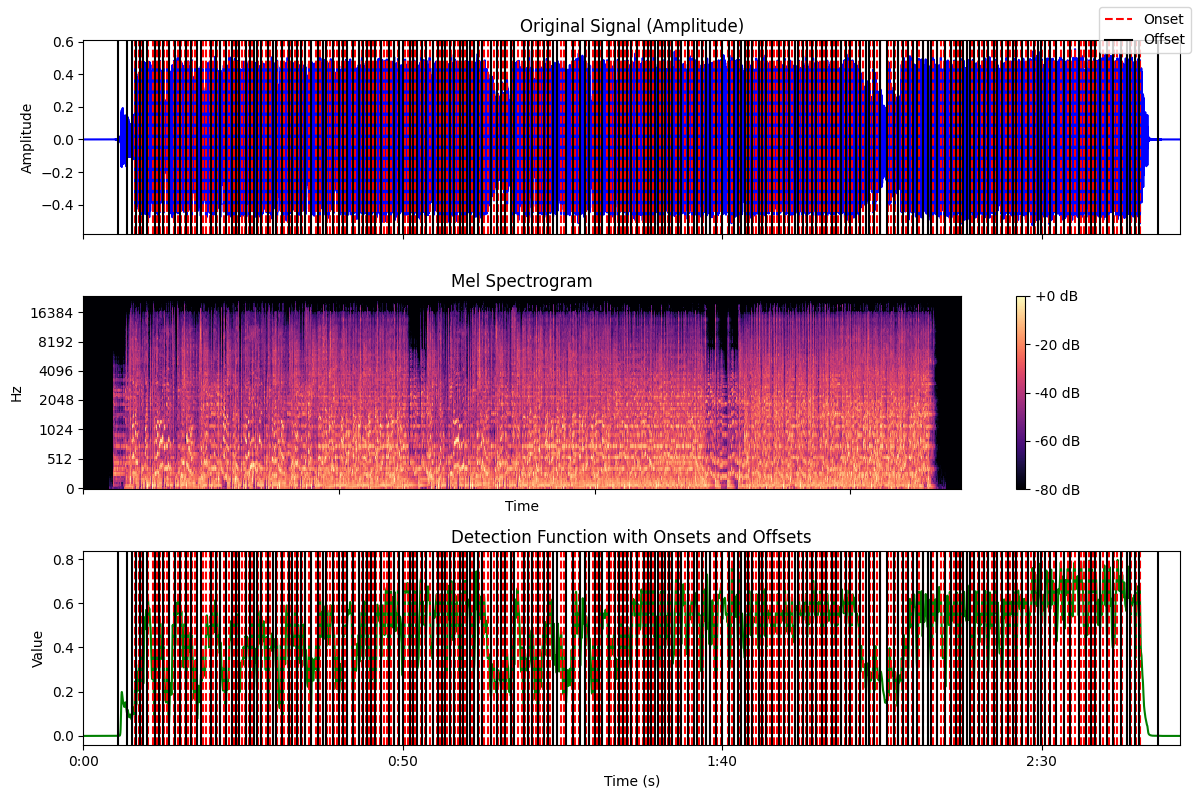

In [ ]:
# 데이터 준비 (샘플 오디오 신호)
y, sr = librosa.load(audio_path, sr=None)  # 오디오 파일 로드
onsets_time = [onset * hop_length / sr for onset in onsets]  # 온셋 시간 변환
offsets_time = [offset * hop_length / sr for offset in offsets]  # 오프셋 시간 변환

# 탐지 함수 준비
frames = np.arange(len(detection_function_smoothed))
time_axis = frames * hop_length / sr

# 스펙트로그램 계산
S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=hop_length, power=2.0)
log_S = librosa.power_to_db(S, ref=np.max)

# 시각화
fig, ax = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# (a) 원래 신호
ax[0].plot(np.linspace(0, len(y) / sr, len(y)), y, color='blue')
ax[0].set_title("Original Signal (Amplitude)")
ax[0].set_ylabel("Amplitude")
for onset in onsets_time:
    ax[0].axvline(onset, color='red', linestyle='--', label="Onset" if onset == onsets_time[0] else "")
for offset in offsets_time:
    ax[0].axvline(offset, color='black', linestyle='-', label="Offset" if offset == offsets_time[0] else "")

# (b) 스펙트로그램
img = librosa.display.specshow(log_S, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', ax=ax[1])
ax[1].set_title("Mel Spectrogram")
fig.colorbar(img, ax=ax[1], format='%+2.0f dB')

# (c) 탐지 함수
ax[2].plot(time_axis, detection_function_smoothed, color='green', label="Detection Function")
for onset in onsets_time:
    ax[2].axvline(onset, color='red', linestyle='--', label="Onset" if onset == onsets_time[0] else "")
for offset in offsets_time:
    ax[2].axvline(offset, color='black', linestyle='-', label="Offset" if offset == offsets_time[0] else "")
ax[2].set_title("Detection Function with Onsets and Offsets")
ax[2].set_xlabel("Time (s)")
ax[2].set_ylabel("Value")

# 범례 추가 및 출력
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.tight_layout()
plt.show()


시각화 이슈로 처음 60초 구간만 시각화 시도

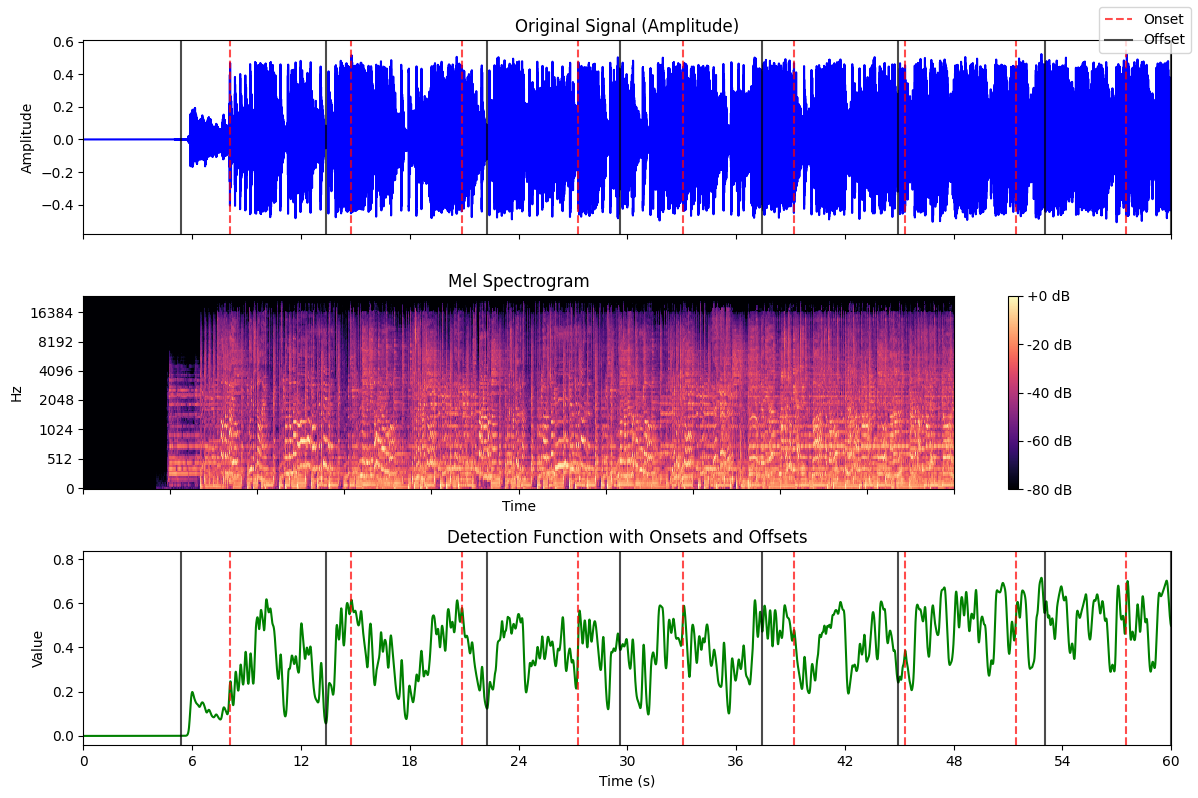

In [ ]:
# 온셋/오프셋 샘플링 (10개마다 하나씩 표시)
sampled_onsets = onsets_time[::10]
sampled_offsets = offsets_time[::10]

# 특정 구간만 시각화 (예: 처음 60초)
time_range_start = 0
time_range_end = 60

# 시각화: 특정 구간에서 간격 조정
fig, ax = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# (a) 원래 신호
ax[0].plot(np.linspace(0, len(y) / sr, len(y)), y, color='blue')
ax[0].set_title("Original Signal (Amplitude)")
ax[0].set_ylabel("Amplitude")
for onset in sampled_onsets:
    ax[0].axvline(onset, color='red', linestyle='--', alpha=0.7, label="Onset" if onset == sampled_onsets[0] else "")
for offset in sampled_offsets:
    ax[0].axvline(offset, color='black', linestyle='-', alpha=0.7, label="Offset" if offset == sampled_offsets[0] else "")
ax[0].set_xlim(time_range_start, time_range_end)

# (b) 스펙트로그램
img = librosa.display.specshow(log_S, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', ax=ax[1])
ax[1].set_title("Mel Spectrogram")
ax[1].set_xlim(time_range_start, time_range_end)
fig.colorbar(img, ax=ax[1], format='%+2.0f dB')

# (c) 탐지 함수
ax[2].plot(time_axis, detection_function_smoothed, color='green', label="Detection Function")
for onset in sampled_onsets:
    ax[2].axvline(onset, color='red', linestyle='--', alpha=0.7, label="Onset" if onset == sampled_onsets[0] else "")
for offset in sampled_offsets:
    ax[2].axvline(offset, color='black', linestyle='-', alpha=0.7, label="Offset" if offset == sampled_offsets[0] else "")
ax[2].set_title("Detection Function with Onsets and Offsets")
ax[2].set_xlabel("Time (s)")
ax[2].set_ylabel("Value")
ax[2].set_xlim(time_range_start, time_range_end)

# 범례 추가 및 출력
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.tight_layout()
plt.show()


1번 그래프: 원래 오디오 시각화.

빨간색 점선: 온셋. 소리가 시작되는 지점

검은색 실선: 오프셋. 소리가 끝나는 지점


2번 그래프: 주파수 변환 멜 스펙트로그램


3번 그래프: 탐지함수를 적용

빨간색 점선: 탐지함수에서 높은 값을 가지는 피크에 해당

검은색 실선: 탐지함수에서 다시 안정화되거나 낮아지는 지점



탐지함수 적용


주어진 오디오에서 온셋과 오프셋을 탐지하기 위해 계산된 신호의 특징을 수치화한 함수. 급격한 에너지 변화에서 온셋과 오프셋을 잘 탐지하도록 함수 적용하는 것임.



# 드럼 추출



'/content/drive/My Drive/soundAI/BoysLikeGirls.mp3'

MagicCarpetRide_drum.mp3

Every Day.mp3

music.mp3 //꿈나라별나라


HPSS

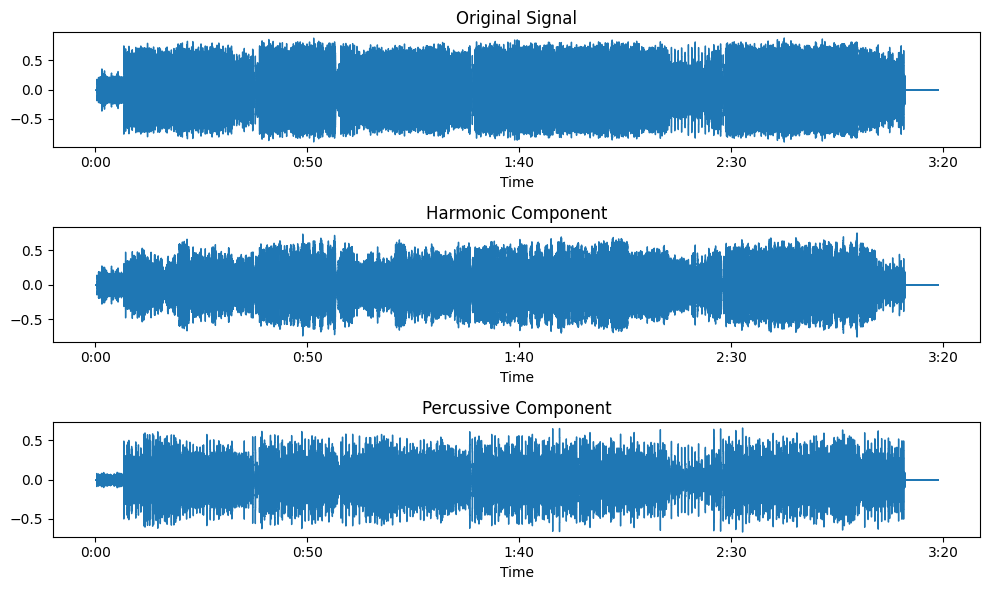

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# 오디오 로드
y, sr = librosa.load('/content/drive/My Drive/soundAI/BoysLikeGirls.mp3', sr=None)

# HPSS 분리
harmonic, percussive = librosa.effects.hpss(y)

# 결과 시각화
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.title("Original Signal")
plt.subplot(3, 1, 2)
librosa.display.waveshow(harmonic, sr=sr)
plt.title("Harmonic Component")
plt.subplot(3, 1, 3)
librosa.display.waveshow(percussive, sr=sr)
plt.title("Percussive Component")
plt.tight_layout()
plt.show()


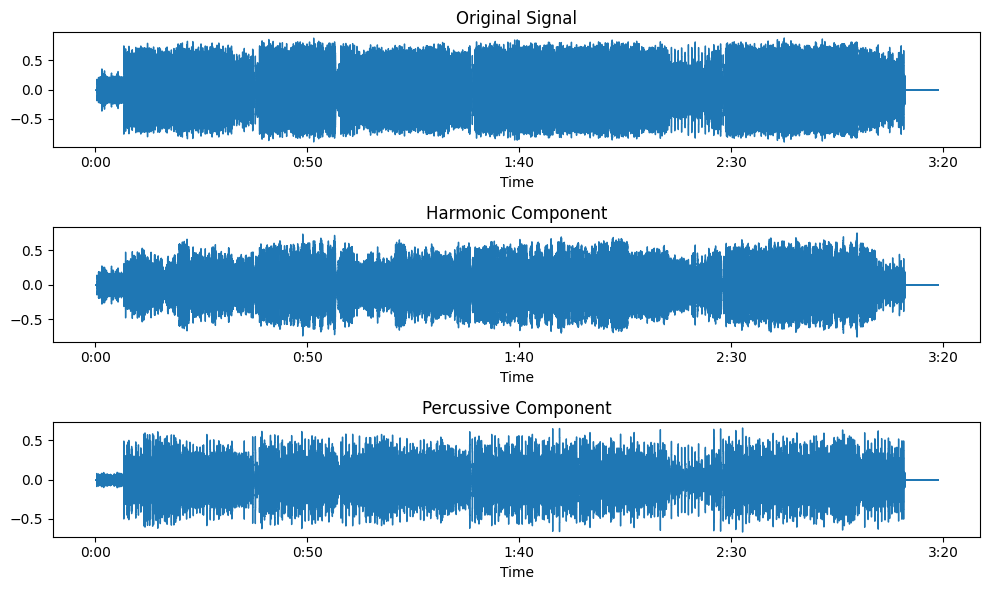

'/content/drive/My Drive/soundAI/Percussive_Component.wav'

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.io.wavfile import write

# 1. 오디오 파일 로드
audio_path = '/content/drive/My Drive/soundAI/BoysLikeGirls.mp3'  # 실제 오디오 경로로 변경
y, sr = librosa.load(audio_path, sr=None)

# 2. HPSS 분리
harmonic, percussive = librosa.effects.hpss(y)

# 3. 분리된 드럼 소리 저장
output_path = "/content/drive/My Drive/soundAI/Percussive_Component.wav"
write(output_path, sr, (percussive * 32767).astype('int16'))  # 16-bit PCM 변환

# 4. 결과 시각화
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.title("Original Signal")
plt.subplot(3, 1, 2)
librosa.display.waveshow(harmonic, sr=sr)
plt.title("Harmonic Component")
plt.subplot(3, 1, 3)
librosa.display.waveshow(percussive, sr=sr)
plt.title("Percussive Component")
plt.tight_layout()
plt.show()

output_path


하,,,, 존나 안 뽑힘

여기서 드럼은 percussive에 해당

스플리터 라이브러리 사용

In [ ]:
!pip install spleeter


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.8/511.8 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 24.

In [ ]:
from spleeter.separator import Separator

# Spleeter로 드럼 분리 (4stem)
separator = Separator('spleeter:4stems')
separator.separate_to_file('/content/drive/My Drive/soundAI/music.mp3', '/content/drive/My Drive/soundAI/')

# 드럼 트랙 파일 경로
drum_path = '/content/drive/My Drive/soundAI/music_drums_1125.wav'
print(f"Drum track saved at: {drum_path}")


Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead
Instructions for updating:
Colocations handled automatically by placer.


INFO:spleeter:File /content/drive/My Drive/soundAI/music/vocals.wav written succesfully


INFO:spleeter:File /content/drive/My Drive/soundAI/music/vocals.wav written succesfully


INFO:spleeter:File /content/drive/My Drive/soundAI/music/drums.wav written succesfully


INFO:spleeter:File /content/drive/My Drive/soundAI/music/drums.wav written succesfully


INFO:spleeter:File /content/drive/My Drive/soundAI/music/bass.wav written succesfully


INFO:spleeter:File /content/drive/My Drive/soundAI/music/bass.wav written succesfully


INFO:spleeter:File /content/drive/My Drive/soundAI/music/other.wav written succesfully


INFO:spleeter:File /content/drive/My Drive/soundAI/music/other.wav written succesfully


Drum track saved at: /content/drive/My Drive/soundAI/music_drums_1125.wav


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 파일 확인
import os
file_path = '/content/drive/My Drive/soundAI/music_drums_1125.wav'
if os.path.exists(file_path):
    print(f"Drum file exists at: {file_path}")
else:
    print("Drum file not found!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drum file not found!


In [ ]:
import os

# music 디렉토리 내 파일 목록 확인
music_dir = '/content/drive/My Drive/soundAI/'
print("Files in directory:")
print(os.listdir(music_dir))


Files in directory:
['df_concat.csv', '0515.ipynb', '서영_0520.ipynb의 사본', '서영_05-(5).ipynb', '서영_0526회의(음).ipynb', '5.27.ipynb', '5_27 (2).ipynb', '6_(1).ipynb', 'EveryDay_drums.wav', 'one_hot_encoded_labels_train.csv', 'one_hot_encoded_labels_test.csv', 'MagicCarpetRide_drum.mp3', 'MagicCarpetRide_drum.wav', 'EveryDay_drums.mid', 'EveryDay_drums.xml', 'MagicCarpetRide.mid', 'MagicCarpetRide.xml', 'MagicCarpetRide_drum.xml', 'Neural Drum Machine.ipynb', 'Every Day.mp3', 'Every Day', 'BoysLikeGirls.mp3', 'BoysLikeGirls', 'best_model', 'best_model.h5', 'resized_stft_images_ED_compressed.npz', '0810채보로직.ipynb', 'predictions.npy', 'predictions_binary_list.npy', 'numbered_predictions_binary_list.npy', '0814.ipynb', 'music.mp3', 'music', 'drum_pattern.ly', '1155.ly', '0810채보로직 (1).ipynb', 'zero_peaks.csv', 'one_peaks.csv', '0930_피크추출.ipynb', 'sliced', '29k', '0914_주파수특징추출.ipynb', '주파수 추출, 클러스터링.ipynb', '1001_주파수변환_평균값.ipynb',

In [ ]:
from google.colab import files

file_path = '/content/drive/My Drive/soundAI/music_drums_1125.wav'
files.download(file_path)


FileNotFoundError: Cannot find file: /content/drive/My Drive/soundAI/music_drums_1125.wav

/content/drive/My Drive/soundAI/music/drums.wav'  -- 잘 추출된 드럼 파일

# 드럼 추출 음원에서 온셋 탐지

/content/drive/My Drive/soundAI/music/drums.wav' -- 잘 추출된 드럼 **파일**

In [ ]:
import librosa

In [ ]:
audio_path = '/content/drive/My Drive/soundAI/music/drums.wav'  # 여기에 mp3 파일 경로를 입력하세요
y, sr = librosa.load(audio_path, sr=None)
